# Battle of the Neighbourhoods - London

In [1]:
#!conda install -c conda-forge folium=0.5.0 
#!pip install geopy

print('packages downloaded.')

packages downloaded.


In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import folium # map rendering library
from sklearn.cluster import KMeans # import k-means from clustering stage
from geopy.geocoders import Nominatim
import re # Importing re package for using regular expressions 

%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


In [3]:
# The code was removed by Watson Studio for sharing.

###### Lets try to get the most popular categories of Food for one Borough (choosing Hillingdon as I live here).

In [4]:
# get latitude and longitude of Hillingdon Borough using coordinates available on wiki page (that will be used later in the code)
geolocator = Nominatim(user_agent="london")
location =geolocator.reverse("51.5441°N, 0.4760°W")
print((location.latitude, location.longitude))

(51.543679850000004, -0.476890783508649)


In [5]:
LIMIT = 100 #limit the number of results
radius = 5000 # search radius
cat_id = '4d4b7105d754a06374d81259' # category id for food
VERSION = '20180605'
hill_latitude = location.latitude
hill_longitude = location.longitude

# note that in the URL sortByPopularity is added to provide top 100 most popular food venues based on location

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}&sortByPopularity = 1'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    hill_latitude, 
    hill_longitude, 
    radius, 
    LIMIT,
    cat_id)


In [6]:
results = requests.get(url).json()

In [7]:
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # flatten JSON

In [8]:
# define a fuction to get venue category
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [10]:
# cleanse the data adding / removing / renaming cloumns
nearby_venues.insert(loc=0, column='rownum', value=np.arange(len(nearby_venues)))
nearbyvenues_group = nearby_venues.groupby("categories").count()
nearbyvenues_group['min_row'] = nearby_venues.groupby("categories")['rownum'].min()
nearbyvenues_group.drop(['id', 'name', 'lat', 'lng'], axis = 1, inplace = True)
nearbyvenues_group.rename(columns={"rownum": "count", "min_row": "rownum"}, inplace = True)
nearbyvenues_group.sort_values(by=['count'], ascending = False)

,count,rownum
categories,,
Fast Food Restaurant,11,11
Chinese Restaurant,8,16
Indian Restaurant,7,7
Pizza Place,6,8
Sandwich Place,5,15
Fish & Chips Shop,4,2
Bakery,4,26
Italian Restaurant,4,17
Burger Joint,3,4


In [11]:
# just for curiosity get the details of the most popular venue per category
top_venues = pd.merge(nearbyvenues_group,nearby_venues,on = "rownum", how = 'inner') 

In [12]:
top_venues.sort_values(by=['count'], ascending = False).head(10)

,count,rownum,id,name,categories,lat,lng
8,11,11,53eca5bc498eef14e3f4585a,KFC,Fast Food Restaurant,51.558206,-0.492614
6,8,16,4bdc75b9fed22d7f024358c9,Go Sing,Chinese Restaurant,51.508947,-0.473809
12,7,7,4d3dd827a2e4b1f7efa7f525,The Breakspear Arms,Indian Restaurant,51.580140,-0.447706
15,6,8,4cc03625985aa35dcd5c4b12,Pizza Hut,Pizza Place,51.547238,-0.479529
18,5,15,4c517b54d797e21ecb171b7c,Subway,Sandwich Place,51.544442,-0.475015
9,4,2,4be1a54858102d7f96294256,Jack's Fish & Chips,Fish & Chips Shop,51.537390,-0.471608
1,4,26,4e1e3ae5152098f789cac8ac,Greggs,Bakery,51.545127,-0.477184
13,4,17,4f22c5cde4b0085e483301c0,Prezzo,Italian Restaurant,51.547329,-0.479845
4,3,4,4bee7ac935dc0f4759dd3f5b,Five Guys,Burger Joint,51.546392,-0.479272
17,3,1,51cad031498eb0c323b3ff24,Javitri,Restaurant,51.549397,-0.482702


###### Lets now perform analysis for all London Boroughs

In [13]:
# read table from Wiki page that has Borough details along with co-ordinates of their offices
wiki_url = 'https://en.wikipedia.org/wiki/List_of_London_boroughs'
wiki_table = pd.read_html(wiki_url, header = 0)

In [14]:
raw_wiki_data = wiki_table[0] # data now available in dataframe raw_data

In [15]:
raw_wiki_data.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"Barnet House, 2 Bristol Avenue, Colindale",33.49,369088,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20


In [16]:
# drop unnecessary columns
raw_wiki_data.drop(['Inner','Status','Local authority','Political control','Headquarters','Area (sq mi)','Population (2013 est)[1]','Nr. in map'], axis = 1, inplace = True)

In [17]:
raw_wiki_data.head()

,Borough,Co-ordinates
0,Barking and Dagenham [note 1],51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E
1,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W
2,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E
3,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W
4,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E


In [18]:
# Function to clean the Borough names  as they contain [notes] e.g. row 0
def Clean_names(borough_name): 
    # Search for opening bracket in the name followed by 
    # any characters repeated any number of times 
    if re.search('\[.*', borough_name): 
  
        # Extract the position of beginning of pattern 
        pos = re.search('\[.*', borough_name).start() 
  
        # return the cleaned name 
        return borough_name[:pos] 
  
    else: 
        # if clean up needed return the same name 
        return borough_name 

In [19]:
raw_wiki_data['Borough'] = raw_wiki_data['Borough'].apply(Clean_names)

In [20]:
raw_wiki_data.head()

,Borough,Co-ordinates
0,Barking and Dagenham,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E
1,Barnet,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W
2,Bexley,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E
3,Brent,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W
4,Bromley,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E


In [21]:
# Function to clean the Borough coordinates to extact 51.5607°N 0.1557°E from 51°33′39″N 0°09′21″E﻿ / 51.5607°N 0.1557°E
def Clean_coordinates(coordinates): 
    # Search for opening bracket in the name followed by 
    # any characters repeated any number of times 
    if re.search('\/.*', coordinates): 
  
        # Extract the position of beginning of pattern 
        pos = re.search('\/.*', coordinates).start() 
  
        # return the cleaned name 
        return coordinates[pos+1:] 
  
    else: 
        # if clean up needed return the same name 
        return coordinates 

In [22]:
raw_wiki_data['Co-ordinates'] = raw_wiki_data['Co-ordinates'].apply(Clean_coordinates)

In [23]:
raw_wiki_data.head()

,Borough,Co-ordinates
0,Barking and Dagenham,﻿51.5607°N 0.1557°E
1,Barnet,﻿51.6252°N 0.1517°W
2,Bexley,﻿51.4549°N 0.1505°E
3,Brent,﻿51.5588°N 0.2817°W
4,Bromley,﻿51.4039°N 0.0198°E


In [24]:
# define function to get list of all food venues for each borough(similar to what was performed for Hillingdon Borough)
def getpopularfoodVenues(names, coordinates):
    
    venues_list=[]
    
    for name, coordinate in zip(names, coordinates):
        print(name)
    
        # convert coordinates to latitude and longitude
        geolocator = Nominatim(user_agent="london")
        location = geolocator.reverse(coordinate)
        lat = location.latitude
        lng = location.longitude
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}&sortByPopularity = 1'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                LIMIT,
                cat_id)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearbyvenues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearbyvenues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearbyvenues)

In [25]:
london_data = getpopularfoodVenues(names=raw_wiki_data['Borough'],
                                   coordinates = raw_wiki_data['Co-ordinates']
                                  )

Barking and Dagenham 
Barnet
Bexley
Brent
Bromley
Camden
Croydon
Ealing
Enfield
Greenwich 
Hackney
Hammersmith and Fulham 
Haringey
Harrow
Havering
Hillingdon
Hounslow
Islington
Kensington and Chelsea
Kingston upon Thames
Lambeth
Lewisham
Merton
Newham
Redbridge
Richmond upon Thames
Southwark
Sutton
Tower Hamlets
Waltham Forest
Wandsworth
Westminster


In [26]:
print(london_data.shape)
london_data.head()

(2961, 7)


,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Barking and Dagenham,51.560759,0.155644,Teapot Cafe,51.579782,0.182306,Café
1,Barking and Dagenham,51.560759,0.155644,Ciao Bella,51.576103,0.182819,Italian Restaurant
2,Barking and Dagenham,51.560759,0.155644,The Greyhound (Harvester),51.568429,0.119456,English Restaurant
3,Barking and Dagenham,51.560759,0.155644,Nando's,51.562640,0.219148,Portuguese Restaurant
4,Barking and Dagenham,51.560759,0.155644,Braza,51.576344,0.181760,Brazilian Restaurant


In [27]:
# remove dupicates if any
london_data.drop_duplicates()
print('Duplicates if any were dropped')

Duplicates if any were dropped


In [28]:
london_data.shape

(2961, 7)

In [29]:
london_data.insert(loc=0, column='rownum', value=np.arange(len(london_data)))

In [30]:
london_data.head()

,rownum,Borough,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Barking and Dagenham,51.560759,0.155644,Teapot Cafe,51.579782,0.182306,Café
1,1,Barking and Dagenham,51.560759,0.155644,Ciao Bella,51.576103,0.182819,Italian Restaurant
2,2,Barking and Dagenham,51.560759,0.155644,The Greyhound (Harvester),51.568429,0.119456,English Restaurant
3,3,Barking and Dagenham,51.560759,0.155644,Nando's,51.562640,0.219148,Portuguese Restaurant
4,4,Barking and Dagenham,51.560759,0.155644,Braza,51.576344,0.181760,Brazilian Restaurant


In [31]:
# one hot encoding
londononehot_enc = pd.get_dummies(london_data[['Venue Category']], prefix="", prefix_sep="")

In [32]:
# add and move Borough column to front of the dataframe
londononehot_enc.insert(0,'Borough',london_data['Borough']) 

print(londononehot_enc.shape)
londononehot_enc.head()

(2961, 109)


,Borough,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,...,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Barking and Dagenham,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
london_grouped = londononehot_enc.groupby('Borough').mean().reset_index()
print(london_grouped.shape)
london_grouped.head()

(32, 109)


,Borough,Afghan Restaurant,African Restaurant,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,...,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Thai Restaurant,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint,Xinjiang Restaurant
0,Barking and Dagenham,0.0,0.0,0.035088,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.017544,0.017544,0.0,0.0,0.000000,0.0,0.0
1,Barnet,0.0,0.0,0.010000,0.0,0.0,0.010000,0.0,0.0,0.0,...,0.0,0.0,0.010000,0.020000,0.110000,0.0,0.0,0.010000,0.0,0.0
2,Bexley,0.0,0.0,0.035088,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.017544,0.0,0.0
3,Brent,0.0,0.0,0.010000,0.0,0.0,0.020000,0.0,0.0,0.0,...,0.0,0.0,0.010000,0.010000,0.000000,0.0,0.0,0.000000,0.0,0.0
4,Bromley,0.0,0.0,0.020619,0.0,0.0,0.010309,0.0,0.0,0.0,...,0.0,0.0,0.010309,0.010309,0.020619,0.0,0.0,0.000000,0.0,0.0


In [34]:
# function to get most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [35]:
# get top 10 venues for each neighbourhood
num_top_venues = 10 

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
london_borough_venues_sorted = pd.DataFrame(columns=columns)
london_borough_venues_sorted['Borough'] = london_grouped['Borough']

for ind in np.arange(london_grouped.shape[0]):
    london_borough_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], num_top_venues)

    
print(london_borough_venues_sorted.shape)
london_borough_venues_sorted.head()

(32, 11)


,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barking and Dagenham,Fast Food Restaurant,Café,Pizza Place,Italian Restaurant,Bakery,English Restaurant,Restaurant,Sandwich Place,American Restaurant,Steakhouse
1,Barnet,Café,Turkish Restaurant,Greek Restaurant,Bakery,Italian Restaurant,Mediterranean Restaurant,Indian Restaurant,Pizza Place,Middle Eastern Restaurant,French Restaurant
2,Bexley,Fast Food Restaurant,Italian Restaurant,Pizza Place,Café,Indian Restaurant,Bakery,English Restaurant,Sandwich Place,Gastropub,American Restaurant
3,Brent,Indian Restaurant,Sandwich Place,Fast Food Restaurant,Pizza Place,Burger Joint,Italian Restaurant,Middle Eastern Restaurant,Portuguese Restaurant,Café,Chinese Restaurant
4,Bromley,Pizza Place,Indian Restaurant,Café,Fast Food Restaurant,Italian Restaurant,Sandwich Place,Gastropub,Fish & Chips Shop,English Restaurant,Sushi Restaurant


In [36]:
keval_list = []
london_grouped_clustering = london_grouped.drop('Borough', 1)  

In [37]:
# run k-means clustering for value of K from 1 to 10 and get inertia which will help find right vlaue of k
for k in range(1,11):
    km = KMeans(n_clusters=k, random_state=0).fit(london_grouped_clustering)
    keval_list.append([k,km.inertia_])

In [38]:
keval = pd.DataFrame(keval_list)

In [39]:
# rename columns
keval.columns = ['k Value', 'Inertia']

In [40]:
keval.set_index('k Value', inplace = True)
keval.index = keval.index.map(int)

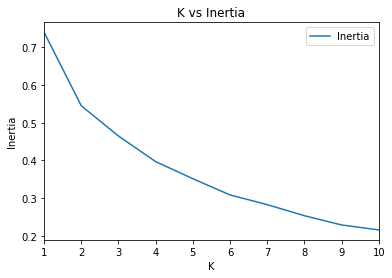

In [41]:
keval.plot(kind='line')

plt.title('K vs Inertia')
plt.ylabel('Inertia')
plt.xlabel('K')

plt.show()

###### Above plot shows that the inertia significantly dropped for K value 2 so lets choose this to perform final analysis

In [42]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(london_grouped_clustering)

In [43]:
london_borough_venues_sorted.insert(0,'Cluster Labels',kmeans.labels_)

In [44]:
london_borough_venues_sorted.shape

(32, 12)

In [45]:
london_merged = london_borough_venues_sorted.merge(london_data.drop_duplicates(subset = ['Borough']), how = 'left')

In [46]:
print(london_merged.shape)
london_merged.head()

(32, 19)


,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,rownum,Borough Latitude,Borough Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Barking and Dagenham,Fast Food Restaurant,Café,Pizza Place,Italian Restaurant,Bakery,English Restaurant,Restaurant,Sandwich Place,American Restaurant,Steakhouse,0,51.560759,0.155644,Teapot Cafe,51.579782,0.182306,Café
1,1,Barnet,Café,Turkish Restaurant,Greek Restaurant,Bakery,Italian Restaurant,Mediterranean Restaurant,Indian Restaurant,Pizza Place,Middle Eastern Restaurant,French Restaurant,57,51.625429,-0.151787,Boyden's Kitchen,51.615233,-0.146136,Café
2,0,Bexley,Fast Food Restaurant,Italian Restaurant,Pizza Place,Café,Indian Restaurant,Bakery,English Restaurant,Sandwich Place,Gastropub,American Restaurant,157,51.454575,0.150452,Carved,51.456952,0.143107,American Restaurant
3,0,Brent,Indian Restaurant,Sandwich Place,Fast Food Restaurant,Pizza Place,Burger Joint,Italian Restaurant,Middle Eastern Restaurant,Portuguese Restaurant,Café,Chinese Restaurant,214,51.558862,-0.281428,Boxpark Wembley,51.560444,-0.280153,Food Court
4,0,Bromley,Pizza Place,Indian Restaurant,Café,Fast Food Restaurant,Italian Restaurant,Sandwich Place,Gastropub,Fish & Chips Shop,English Restaurant,Sushi Restaurant,314,51.404165,0.020446,Havet,51.406184,0.013522,Turkish Restaurant


In [47]:
# drop unnecessary columns
london_merged.drop(['rownum','Venue','Venue Latitude','Venue Longitude','Venue Category'], axis = 1, inplace = True)
london_merged.head()

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough Latitude,Borough Longitude
0,0,Barking and Dagenham,Fast Food Restaurant,Café,Pizza Place,Italian Restaurant,Bakery,English Restaurant,Restaurant,Sandwich Place,American Restaurant,Steakhouse,51.560759,0.155644
1,1,Barnet,Café,Turkish Restaurant,Greek Restaurant,Bakery,Italian Restaurant,Mediterranean Restaurant,Indian Restaurant,Pizza Place,Middle Eastern Restaurant,French Restaurant,51.625429,-0.151787
2,0,Bexley,Fast Food Restaurant,Italian Restaurant,Pizza Place,Café,Indian Restaurant,Bakery,English Restaurant,Sandwich Place,Gastropub,American Restaurant,51.454575,0.150452
3,0,Brent,Indian Restaurant,Sandwich Place,Fast Food Restaurant,Pizza Place,Burger Joint,Italian Restaurant,Middle Eastern Restaurant,Portuguese Restaurant,Café,Chinese Restaurant,51.558862,-0.281428
4,0,Bromley,Pizza Place,Indian Restaurant,Café,Fast Food Restaurant,Italian Restaurant,Sandwich Place,Gastropub,Fish & Chips Shop,English Restaurant,Sushi Restaurant,51.404165,0.020446


In [48]:
# get latitude and longitude of London
lon_address = 'London, England'

geolocator = Nominatim(user_agent="london")
lon_location = geolocator.geocode(lon_address)
lon_latitude = lon_location.latitude
lon_longitude = lon_location.longitude

print('The geograpical coordinate of London are {}, {}.'.format(lon_latitude, lon_longitude))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [49]:
# Plot the Map to analyse the clusters
import matplotlib.cm as cm
import matplotlib.colors as colors

kclusters = 2

# create map
map_clusters = folium.Map(location=[lon_latitude, lon_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(london_merged['Borough Latitude'], london_merged['Borough Longitude'], london_merged['Borough'], london_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [50]:
london_merged.loc[london_merged['Cluster Labels'] == 0]

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough Latitude,Borough Longitude
0,0,Barking and Dagenham,Fast Food Restaurant,Café,Pizza Place,Italian Restaurant,Bakery,English Restaurant,Restaurant,Sandwich Place,American Restaurant,Steakhouse,51.560759,0.155644
2,0,Bexley,Fast Food Restaurant,Italian Restaurant,Pizza Place,Café,Indian Restaurant,Bakery,English Restaurant,Sandwich Place,Gastropub,American Restaurant,51.454575,0.150452
3,0,Brent,Indian Restaurant,Sandwich Place,Fast Food Restaurant,Pizza Place,Burger Joint,Italian Restaurant,Middle Eastern Restaurant,Portuguese Restaurant,Café,Chinese Restaurant,51.558862,-0.281428
4,0,Bromley,Pizza Place,Indian Restaurant,Café,Fast Food Restaurant,Italian Restaurant,Sandwich Place,Gastropub,Fish & Chips Shop,English Restaurant,Sushi Restaurant,51.404165,0.020446
6,0,Croydon,Indian Restaurant,Café,Pizza Place,Fast Food Restaurant,Sandwich Place,Bakery,Mediterranean Restaurant,Breakfast Spot,Portuguese Restaurant,Chinese Restaurant,51.370920,-0.097673
8,0,Enfield,Turkish Restaurant,Café,Fast Food Restaurant,Bakery,Pizza Place,Greek Restaurant,Indian Restaurant,Italian Restaurant,Sandwich Place,Fish & Chips Shop,51.653812,-0.079900
9,0,Greenwich,Café,Fast Food Restaurant,Pizza Place,Turkish Restaurant,Italian Restaurant,Indian Restaurant,Gastropub,Thai Restaurant,Bakery,Fish & Chips Shop,51.489268,0.065451
13,0,Harrow,Indian Restaurant,Fast Food Restaurant,Sandwich Place,Pizza Place,Bakery,Café,Italian Restaurant,Portuguese Restaurant,Fish & Chips Shop,Gastropub,51.590044,-0.335059
14,0,Havering,Café,Fast Food Restaurant,Bakery,Pizza Place,Italian Restaurant,Restaurant,English Restaurant,Sandwich Place,American Restaurant,Portuguese Restaurant,51.581349,0.183973
15,0,Hillingdon,Fast Food Restaurant,Chinese Restaurant,Indian Restaurant,Pizza Place,Sandwich Place,Italian Restaurant,Bakery,Fish & Chips Shop,Burger Joint,Restaurant,51.543680,-0.476891


In [51]:
london_merged.loc[london_merged['Cluster Labels'] == 1]

,Cluster Labels,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Borough Latitude,Borough Longitude
1,1,Barnet,Café,Turkish Restaurant,Greek Restaurant,Bakery,Italian Restaurant,Mediterranean Restaurant,Indian Restaurant,Pizza Place,Middle Eastern Restaurant,French Restaurant,51.625429,-0.151787
5,1,Camden,Steakhouse,Indian Restaurant,Bakery,Sushi Restaurant,Breakfast Spot,Pizza Place,Seafood Restaurant,Café,English Restaurant,Burger Joint,51.529064,-0.125360
7,1,Ealing,Café,Italian Restaurant,Bakery,Middle Eastern Restaurant,French Restaurant,Pizza Place,Indian Restaurant,Thai Restaurant,Gastropub,Japanese Restaurant,51.513250,-0.308882
10,1,Hackney,Café,Bakery,Restaurant,Pizza Place,Italian Restaurant,Vietnamese Restaurant,Turkish Restaurant,Gastropub,Deli / Bodega,Breakfast Spot,51.544755,-0.054942
11,1,Hammersmith and Fulham,Café,Bakery,Gastropub,Pizza Place,Italian Restaurant,Burger Joint,French Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Fish & Chips Shop,51.492548,-0.233786
12,1,Haringey,Café,Turkish Restaurant,Italian Restaurant,Bakery,Greek Restaurant,Pizza Place,Japanese Restaurant,Mediterranean Restaurant,Indian Restaurant,Gastropub,51.600327,-0.112027
17,1,Islington,Bakery,Café,Pizza Place,Italian Restaurant,Breakfast Spot,Indian Restaurant,Middle Eastern Restaurant,Mediterranean Restaurant,Turkish Restaurant,Restaurant,51.541753,-0.102106
18,1,Kensington and Chelsea,Italian Restaurant,Café,Restaurant,French Restaurant,Bakery,Japanese Restaurant,Pizza Place,Gastropub,Indian Restaurant,Turkish Restaurant,51.502149,-0.195075
19,1,Kingston upon Thames,Café,Korean Restaurant,Italian Restaurant,Gastropub,Japanese Restaurant,Pizza Place,Burger Joint,Portuguese Restaurant,Restaurant,Thai Restaurant,51.408358,-0.305937
20,1,Lambeth,Café,Pizza Place,Gastropub,Italian Restaurant,Restaurant,Bakery,French Restaurant,Deli / Bodega,Indian Restaurant,Burger Joint,51.460618,-0.116942


##### From the above analysis it seems that as we move closer to London City  Cafes and bakery shops become more popular. As we move away from the city restaurants take a hold of popularity.